In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.cluster import KMeans
from collections import Counter
import base64, requests, json, os
from dotenv import load_dotenv

In [2]:
load_dotenv()
os.environ["WHAT_FONT_IS"] = os.getenv("WHAT_FONT_IS")


In [3]:
model = YOLO('best.pt', task='segment')
standard_width_mm = 520
standard_height_mm = 118

dpi = 96
pixels_per_mm = dpi / 25.4


In [4]:
target_width_px = int(standard_width_mm * pixels_per_mm)
target_height_px = int(standard_height_mm * pixels_per_mm)


In [5]:
def draw_segments(image, results):
    result = results[0]
    masks = result.masks.data.cpu().numpy()

    for mask in masks:
        mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask_resized = mask_resized.astype(bool)
        color_mask = np.zeros_like(image, dtype=np.uint8)
        color_mask[mask_resized] = (0, 255, 0)
        alpha = 0.5
        image = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)
    return image


In [6]:
def crop_segment(image, results):
    boxes = results[0].boxes.xyxy.cpu().numpy()
    masks = results[0].masks.data.cpu().numpy()

    cropped_images = []
    for box, mask in zip(boxes, masks):
        x1, y1, x2, y2 = map(int, box[:4])
        mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask_resized = mask_resized.astype(bool)
        
        cropped_image = image[y1:y2, x1:x2]
        mask_cropped = mask_resized[y1:y2, x1:x2]
        
        cropped_image = cv2.bitwise_and(cropped_image, cropped_image, mask=mask_cropped.astype(np.uint8))
        cropped_images.append(cropped_image)

    return cropped_images


In [7]:
def load_and_resize_image(image_path, target_width_px, target_height_px):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at the path: {image_path}")
    
    resized_image = cv2.resize(image, (target_width_px, target_height_px), interpolation=cv2.INTER_LINEAR)
    return resized_image


In [8]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    return morph


In [9]:
def segment_characters(edged_image):
    contours, _ = cv2.findContours(edged_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    characters = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        if 0.01 * target_width_px < w < 0.2 * target_width_px and 0.2 * target_height_px < h < 0.9 * target_height_px and 0.1 < aspect_ratio < 1.0:
            characters.append((x, y, w, h))
    characters = sorted(characters, key=lambda c: c[0])
    return characters


In [10]:
def draw_bounding_boxes(image, characters):
    for (x, y, w, h) in characters:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(image)
    plt.axis('off')
    plt.title('License Plate with Bounding Boxes')
    plt.show()
   


In [11]:
def crop_image(image, crop_pixels=4):
    height, width, _ = image.shape
    cropped_image = image[crop_pixels:height-crop_pixels, crop_pixels:width-crop_pixels]
    return cropped_image


In [12]:
def measure_spaces_and_dimensions_mm(characters, pixels_per_mm):
    spaces_mm = []
    dimensions_mm = []
    prev_x = None
    for (x, y, w, h) in characters:
        dimensions_mm.append((x / pixels_per_mm, y / pixels_per_mm, w / pixels_per_mm, h / pixels_per_mm))
        if prev_x is not None:
            space = (x - prev_x) / pixels_per_mm
            spaces_mm.append(space)
        prev_x = x + w
    return spaces_mm, dimensions_mm


In [13]:

def check_character_dimensions(dimensions_mm):
    width_thresholds = [(44, 53), (12, 15)]
    height_threshold = [(72, 87)]
    
    all_pass = True
    
    for (x, y, w, h) in dimensions_mm:
        width_pass = any(lower <= w <= upper for lower, upper in width_thresholds)
        height_pass = any(lower <= h <= upper for lower, upper in height_threshold)
        # print(f"Character at ({x:.2f}, {y:.2f}) - Width: {w:.2f} mm, Height: {h:.2f} mm")
        # print(f"  Width Pass: {width_pass} (within {width_thresholds})")
        # print(f"  Height Pass: {height_pass} (within {height_threshold})")
        
        if not (width_pass and height_pass):
            all_pass = False
    
    if all_pass:
        print("Height and Width is correct")
    else:
        print("Height and Width is incorrect")


In [14]:
def check_spaces_between_characters(spaces_mm):
    space_thresholds = [(8, 14), (30, 34)]
    
    all_pass = True
    
    for i, space in enumerate(spaces_mm):
        space_pass = any(lower <= space <= upper for lower, upper in space_thresholds)
        
        if not space_pass:
            all_pass = False
    
    if all_pass:
        print("Space between characters is correct")
    else:
        print("Space between characters is incorrect")


In [15]:
def check_background_color(background_color, lower_bound_1, upper_bound_1, lower_bound_2, upper_bound_2):
    r, g, b = background_color
    
    def is_within_bounds(lower_bound, upper_bound):
        r_lower, g_lower, b_lower = lower_bound
        r_upper, g_upper, b_upper = upper_bound
        return r_lower <= r <= r_upper and g_lower <= g <= g_upper and b_lower <= b <= b_upper
    
    if is_within_bounds(lower_bound_1, upper_bound_1) or is_within_bounds(lower_bound_2, upper_bound_2):
        print("Background color of the License is Valid")
    else:
        print("Background color of the License is invalid")

In [16]:
def smooth_and_sharpen_image(image):
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel)
    return sharpened


In [17]:
def smooth_and_sharpen_image_2(image):
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    kernel = np.array([[0, -1, 0],
                       [-1, 6, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel)
    return sharpened

In [18]:
def extract_background_color(image, k=3):
    image_rgb = image
    pixels = image_rgb.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    cluster_centers = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_
    label_counts = Counter(labels)
    most_common_label = label_counts.most_common(1)[0][0]
    background_color = tuple(cluster_centers[most_common_label])
    return background_color


In [19]:
def print_measurements_mm(dimensions_mm, spaces_mm):
    for i, (x, y, w, h) in enumerate(dimensions_mm):
        # print(f"Character {i+1}:")
        (69,74)
        # print(f"  Width (mm): {w:.2f} {'Pass' if 44 <= w <= 53 or 12 <= w <= 15 else 'Fail'}")
        # print(f"  Height (mm): {h:.2f} {'Pass' if 72 <= h <= 87 else 'Fail'}")
    for i, space in enumerate(spaces_mm):
        print(f"Space between character {i+1} and {i+2} (mm): {space:.2f}")


In [20]:
def convert_image_to_base64(image):
    _, buffer = cv2.imencode('.jpg', image)
    base64_string = base64.b64encode(buffer).decode('utf-8')
    return base64_string


In [21]:
def send_image_for_font_detection(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    base64_string = convert_image_to_base64(image)
    url = 'https://www.whatfontis.com/api2/'
    data = {
        'urlimagebase64': str(base64_string),
        'API_KEY': str(os.getenv("WHAT_FONT_IS")),
        'IMAGEBASE64': 1,
        'NOTTEXTBOXSDETECTION': 0,
        'urlimage': '',
        'limit': 15,
    }
    response = requests.post(url, data=data)
    if response.status_code == 200:
        # print('Request was successful.')
        response_json = response.json()
        # print('Response:', response_json)
        
        correct_fonts = ["Charles Wright Bold", "Charles Wright Motorcycle","Charles Wright 1935","Charles Wright Medium", "Charles Wright Bold Caps", "UKNumberPlate", "British Vehicle JNL Regular"]
        detected_fonts = [font['title'] for font in response_json]
        
        if any(font in correct_fonts for font in detected_fonts):
            print("Font of the content is valid")
        else:
            print("Font of the content is invalid")
    else:
        print('Request failed.')
        print('Status code:', response.status_code)
        # print('Response:', response.text)


0: 768x448 1 plate, 252.4ms
Speed: 0.0ms preprocess, 252.4ms inference, 13.7ms postprocess per image at shape (1, 3, 768, 448)


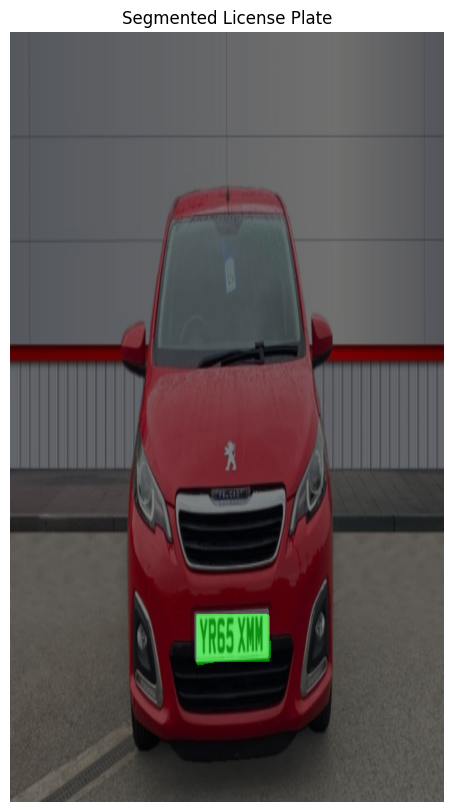

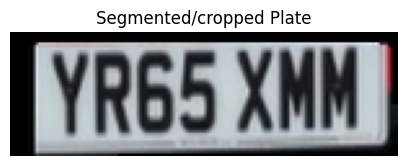

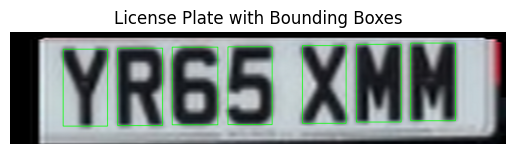

Height and Width is correct
Space between characters is correct
Background color of the License is Valid
Font of the content is valid


In [69]:
def main(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at the path: {image_path}")

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        size = (650, 680)
        # Addition
        height, width, _ = image_rgb.shape
        aspect_ratio = height / width
        
        
        target_height = 680
        target_width = int(target_height / aspect_ratio)
        
        # Ensure height is greater than width
        if target_width > target_height:
            target_width, target_height = target_height, target_width
        
        image_rgb = cv2.resize(image_rgb, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
        
        results = model.predict(source=image_rgb, save=False, conf=0.60)
        
        segmented_image = draw_segments(image_rgb.copy(), results)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(segmented_image)
        plt.axis('off')
        plt.title('Segmented License Plate')
        plt.show()
        
        cropped_images = crop_segment(image_rgb, results)

        for i, cropped_image in enumerate(cropped_images):
            plt.figure(figsize=(5, 5))
            cropped_image = cv2.resize(cropped_image, (150, 48), interpolation=cv2.INTER_LANCZOS4)

            plt.imshow(cropped_image)
            plt.axis('off')
            plt.title('Segmented/cropped Plate')
            plt.show()



        for cropped_image in cropped_images:
            while True:
                
                background_check_img = cropped_image
                resized_image = cv2.resize(cropped_image, (target_width_px, target_height_px), interpolation=cv2.INTER_LANCZOS4)
               
                processed_image = preprocess_image(resized_image)
                characters = segment_characters(processed_image)
                
                if len(characters) == 7:
                    resized_image_with_boxes = resized_image.copy()
                    resized_image_with_boxes = smooth_and_sharpen_image(resized_image_with_boxes)
                    draw_bounding_boxes(resized_image_with_boxes, characters)
                    spaces_mm, dimensions_mm = measure_spaces_and_dimensions_mm(characters, pixels_per_mm)
                    
                    check_character_dimensions(dimensions_mm)
                    check_spaces_between_characters(spaces_mm)
                    
                    background_color = extract_background_color(background_check_img)
                
                    lower_bound_1 = (147, 154, 163)  # Example lower bound for first threshold
                    upper_bound_1 = (255, 255, 255)  # Example upper bound for first threshold
                    lower_bound_2 = (166, 116, 3)  # Example lower bound for second threshold
                    upper_bound_2 = (250, 207, 110)  # Example upper bound for second threshold
                    check_background_color(background_color, lower_bound_1, upper_bound_1, lower_bound_2, upper_bound_2)
                    
                    
                    # print_measurements_mm(dimensions_mm, spaces_mm)

                    # print(f"The background color of the number plate is: {background_color}")
                    
                    font_image = smooth_and_sharpen_image_2(resized_image)
                    send_image_for_font_detection(font_image)
    
                    break
                else:
                    cropped_image = crop_image(resized_image)
                    if cropped_image.size == 0:
                        print("Image cannot be cropped further.")
                        break

    except FileNotFoundError as e:
        print(e)

if __name__ == "__main__":
    image_path = r'E:\DESKTOP\RapidLabs\Milestone_1\number platedataset\25.jpg' 
    main(image_path)